In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

State Variable (Y)

1) Y = [θ, ω, ] ; [angle; ang_vel]
2) dY/dt = [ω, α] ; [ang_vel, ang_accel]

In [2]:
class MotorSim():
    def __init__(self, dt = 0.1, inertia=1, damping=1, springk=0, y0=0, yd0=0):
        self.dt = dt
        self.time = torch.zeros((1))
        self.Y = torch.tensor((y0, yd0), dtype=torch.float32)
        self.vel_old = torch.zeros((1))
        self.acc = torch.zeros((1))
        # Motor Parameters
        self.Inertia = inertia
        self.Damping = damping
        self.SpringConstant = springk 
        self.Torque_Motor = 0
        self.Torque_Shaft = 0
        
        # Logging Stuff
        self.data_dict = {}
        self.data_dict["Time"] = []
        self.data_dict["Pos"] = []
        self.data_dict["Vel"] = []
        self.data_dict["Acc"] = []
        self.data_dict["Torque"] = []
        self.data_dict["Power"] = []

        print("Starting Motor Sim")
        print("Initial State (θ, ω) : {}".format(self.Y))
        
    def step(self, input_torque):
        self.data_dict["Time"].append(self.time.clone().numpy())
        self.data_dict["Pos"].append(self.Y[0].clone().numpy())
        self.data_dict["Vel"].append(self.Y[1].clone().numpy())
        self.data_dict["Torque"].append(input_torque.clone().numpy())
        
        self.Y = self.rk4(self.time, self.Y, input_torque)
        
        # Calculate Accel
        vel_diff = self.Y[1] - self.vel_old
        self.acc = vel_diff/self.dt
        self.data_dict["Acc"].append(self.acc.clone().numpy())
        self.vel_old = self.Y[1].clone()
        # Calculate Mechanical Power
        PowMech = input_torque*self.Y[1] - self.Damping*self.Y[1]*self.Y[1]
        self.data_dict["Power"].append(PowMech.clone().numpy())
        
        self.time += self.dt
        
    def rk4(self, t, Y, input_torque):
        k1 = self.fun(t, Y, input_torque)
        k2 = self.fun(t + self.dt/2, Y + self.dt * k1/2, input_torque)
        k3 = self.fun(t + self.dt/2, Y + self.dt * k2/2, input_torque)
        k4 = self.fun(t + self.dt, Y + self.dt * k3, input_torque)
        Y += (1/6)*self.dt*(k1 + 2*k2 + 2*k3 + k4)
        return Y
    
    def fun(self, t, Y, input_torque):
        accel = self.physics(t, Y, input_torque)
        dYdt = torch.cat( (Y[1, None], accel[None]), dim=0 )
        return dYdt
    
    def physics(self, t, Y, input_torque):
        accel = (input_torque - self.Damping*Y[1] - self.SpringConstant*Y[0])/self.Inertia        
        return accel
    
    def plot(self):
        f, ( (ax1, ax2), (ax3, ax4) ) = plt.subplots(2, 2, figsize=(20, 20))

        y_max = 2
        y_min = -y_max

        ax1.plot(self.data_dict["Time"], self.data_dict["Torque"])
        ax1.set_title("Input Torque")
        ax1.set_ylim([y_min, y_max])
        ax1.set_xlabel("Time (s)")
        ax1.set_ylabel("Torque (nm)")
        ax1.grid(True)

        ax2.plot(self.data_dict["Time"], self.data_dict["Pos"])
        ax2.set_title("Position")
        ax2.set_ylim([y_min, y_max])
        ax2.set_xlabel("Time (s)")
        ax2.set_ylabel("Pos (rad)")
        ax2.grid(True)

        ax3.plot(self.data_dict["Time"], self.data_dict["Vel"])
        ax3.plot(self.data_dict["Time"], self.data_dict["Acc"])
        ax3.set_title("Velocity / Acceleration")
        ax3.set_xlabel("Time (s)")
        ax3.set_ylabel("Vel (rad/s), Accel (rad/s/s")
        ax3.set_ylim([y_min, y_max])
        ax3.grid(True)
        ax3.legend(['Velocity', 'Acceleration'])
        
        ax4.plot(self.data_dict["Time"], self.data_dict["Power"])
        ax4.set_title("Mechanical Power")
        ax4.set_ylim([y_min, y_max])
        ax4.set_xlabel("Time (s)")
        ax4.set_ylabel("Power (W)")
        ax4.grid(True)
        
        plt.show()
    


Starting Motor Sim
Initial State (θ, ω) : tensor([1., 0.])


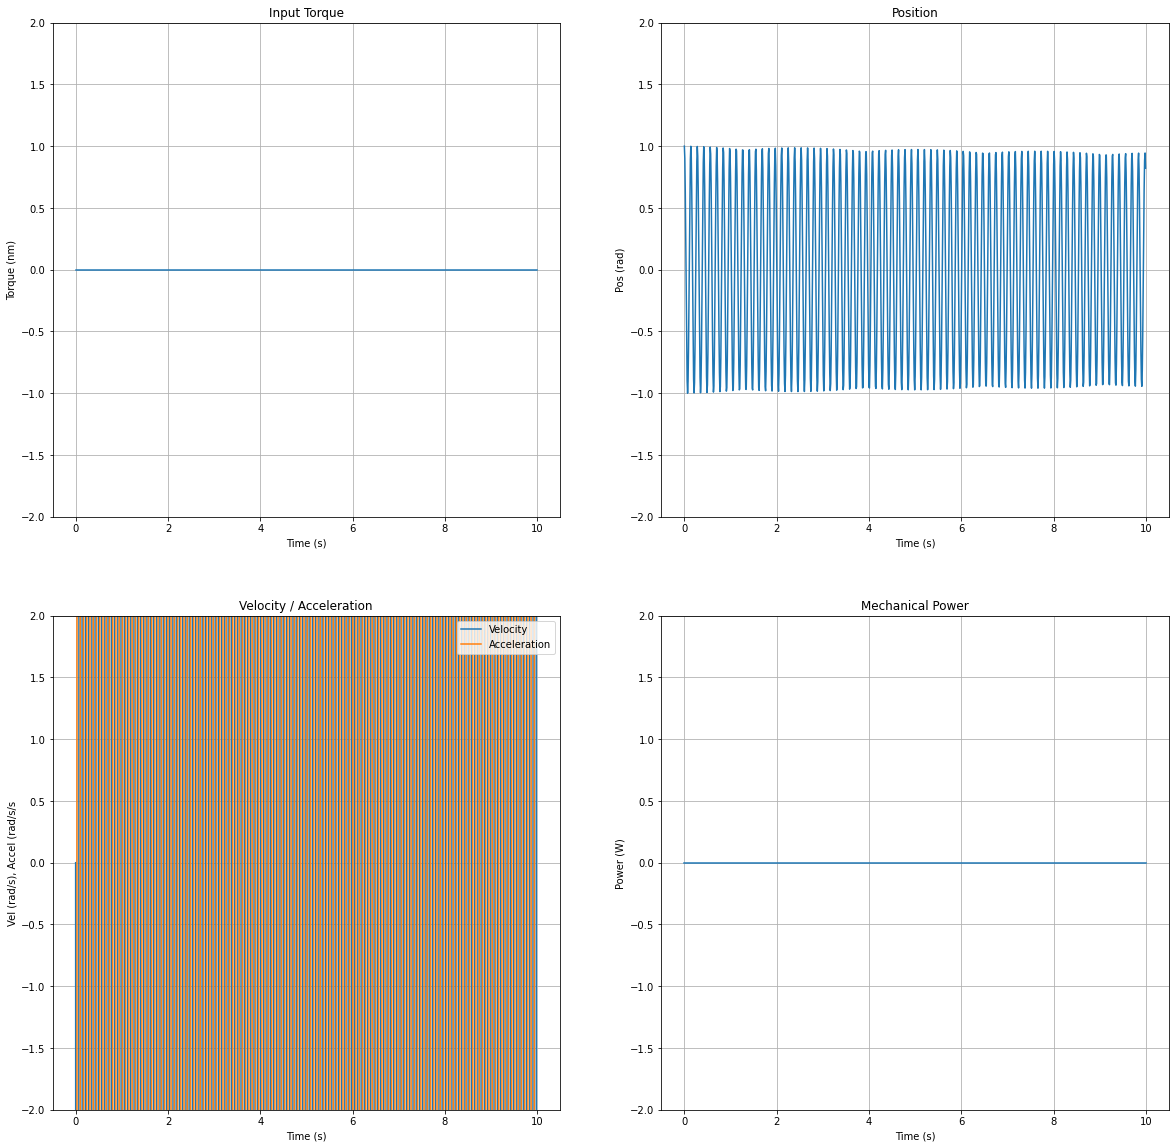

In [12]:
def torque_function(time):
    torque = torch.cos(time)*0
    return torque

ms = MotorSim(dt=0.01, inertia=1, damping=0, springk=2000, y0=1, yd0=0)
# ms.Y[0] = -1

motor_torque = torque_function(ms.time)
for _ in range(1000):
    ms.step(motor_torque[0])
    motor_torque = torque_function(ms.time)    
    
ms.plot()
# ms.data_dict['Torque']

In [ ]:

plt.plot([1, 2, 3, 4])
plt.ylabel('some numbers')
plt.show()